In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import scipy
import matplotlib
import matplotlib.pyplot as plt
import pathlib
from config import Config
import utils
import model as modellib
import visualize

from model import log
from skimage.color import rgb2gray
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
import pandas as pd
%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

print(ROOT_DIR)

train_dir = os.path.join(ROOT_DIR,"stage1_train")
TEST_PATH = os.path.join(ROOT_DIR,"stage1_test")
training_paths = pathlib.Path(train_dir).glob('*/images/*.png')
training_sorted = sorted([x for x in training_paths])
train_ids = next(os.walk(train_dir))[1]
test_ids = next(os.walk(TEST_PATH))[1]
# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)
#print(str(training_sorted[2]).find("\\",48))
#image_id = str(training_sorted[2])[48:112]
#print(str(training_sorted[2]))
#im_path = str(train_dir) +"\\" +image_id + "\\" + "images" + "\\" + image_id + ".png"
#im = imageio.imread(str(im_path))
#masks = [train_dir +'/{}/masks/{}'.format(image_id,m) for m in os.listdir(train_dir + '/{}/masks'.format(image_id))]
#print(len(masks))

C:\Users\cheta\Anaconda2\envs\tensorflow2\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


C:\Users\cheta\Downloads\Mask_RCNN


In [2]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128
    

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[32 32]
 [16 16]
 [ 8  8]
 [ 4  4]
 [ 2  2]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 8
IMAGE_MAX_DIM                  128
IMAGE_MIN_DIM                  128
IMAGE_PADDING                  True
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           shapes
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING         2000
ROI_

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [22]:
class ShapesDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_images(self, count, height, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("data", 1, "nuclei")
        
        training_paths = pathlib.Path(train_dir).glob('*/images/*.png')
        training_sorted = sorted([x for x in training_paths])
        

        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        for i in range(count):
            image_path = train_ids[i]
            im_path = train_dir + '/{}/images/{}.png'.format(image_path, image_path)
            img = cv2.imread(str(im_path))[:,:,:config.IMAGE_SHAPE[2]]
            bg_color = (0, 0, 0)
            self.add_image("data", image_id=str(image_path), path= im_path,
                           width=width, height=height,
                           bg_color=bg_color, image=img)

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        #bg_color = np.array(info['bg_color']).reshape([1, 1, 3])
        #image = np.ones([info['height'], info['width'], 3], dtype=np.uint8)
        #image = image * bg_color.astype(np.uint8)
        #for shape, color, dims in info['shapes']:
         #   image = self.draw_shape(image, shape, dims, color)
        image_path = train_ids[image_id]
        im_path = train_dir + '/{}/images/{}.png'.format(image_path, image_path)
        image = cv2.imread(str(im_path))[:,:,:config.IMAGE_SHAPE[2]]
        return image

    
    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        image_path = train_ids[image_id]
        mask_path = [train_dir +'/{}/masks/{}'.format(image_path,m) for m in os.listdir(train_dir + '/{}/masks'.format(image_path))]    
        mask = []
        for i in range(0,len(mask_path)):
            img = cv2.imread(mask_path[i],0)
            mask.append(img)
        
        masks = np.stack(mask,axis = -1)
        class_ids = np.ones(len(mask_path))
        masks = np.where(masks > 128,1,0)
        return masks, class_ids.astype(np.int32)

  

In [23]:
dataset_train = ShapesDataset()
dataset_train.load_images(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
dataset_val = ShapesDataset()
dataset_val.load_images(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()
image_path = '93c5638e7e6433b5c9cc87c152bcbe28873d2f9d6a392cca0642520807542a77'

mask_path = [train_dir +'/{}/masks/{}'.format(image_path,m) for m in os.listdir(train_dir + '/{}/masks'.format(image_path))]    
mask = []
if(len(mask_path) == 1):
    masks = cv2.imread(mask_path[0],0)
    class_ids = np.ones(1)
else:
    
    for i in range(0,len(mask_path)):
        img = cv2.imread(mask_path[i],0)
        mask.append(img)
    if(len(mask) > 1):
        masks = np.dstack(mask)
        class_ids = np.ones(masks.shape[2])
print(isinstance(masks,np.ndarray))


True


(256, 320, 15)


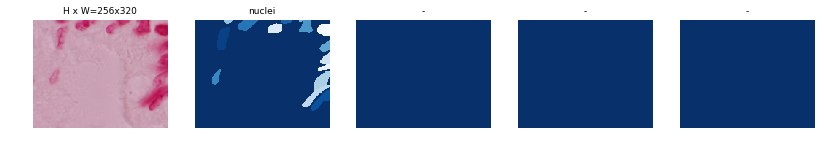

(256, 256, 11)


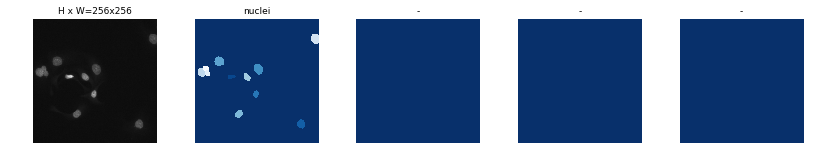

(256, 256, 12)


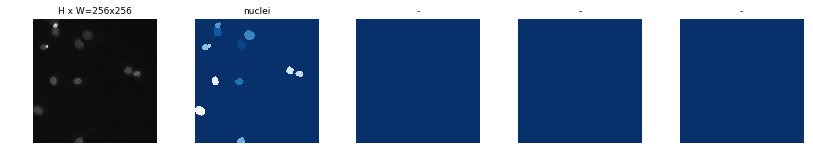

(1024, 1024, 98)


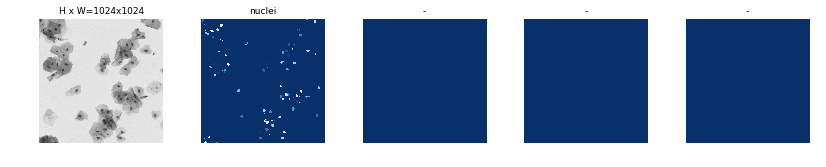

In [25]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)

for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    print(mask.shape)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)


In [26]:
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [27]:
# Which weights to start with?
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

In [28]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: C:\Users\cheta\Downloads\Mask_RCNN\logs\shapes20180319T2328\mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistribute

C:\Users\cheta\Anaconda2\envs\tensorflow2\lib\site-packages\scipy\ndimage\interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\cheta\Anaconda2\envs\tensorflow2\lib\site-packages\tensorflow\python\ops\gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1


 53/100 [==============>...............] - ETA: 14:22 - loss: 2.1960 - rpn_class_loss: 0.1842 - rpn_bbox_loss: 0.9137 - mrcnn_class_loss: 0.2429 - mrcnn_bbox_loss: 0.4041 - mrcnn_mask_loss: 0.45 - ETA: 9:30 - loss: 2.1468 - rpn_class_loss: 0.1800 - rpn_bbox_loss: 0.9330 - mrcnn_class_loss: 0.2435 - mrcnn_bbox_loss: 0.3741 - mrcnn_mask_loss: 0.4163 - ETA: 7:34 - loss: 2.0872 - rpn_class_loss: 0.1774 - rpn_bbox_loss: 0.8721 - mrcnn_class_loss: 0.2273 - mrcnn_bbox_loss: 0.3876 - mrcnn_mask_loss: 0.422 - ETA: 6:18 - loss: 1.9963 - rpn_class_loss: 0.1567 - rpn_bbox_loss: 0.8242 - mrcnn_class_loss: 0.2138 - mrcnn_bbox_loss: 0.3830 - mrcnn_mask_loss: 0.418 - ETA: 6:04 - loss: 2.0301 - rpn_class_loss: 0.1700 - rpn_bbox_loss: 0.8183 - mrcnn_class_loss: 0.2326 - mrcnn_bbox_loss: 0.3921 - mrcnn_mask_loss: 0.417 - ETA: 5:57 - loss: 2.0532 - rpn_class_loss: 0.1775 - rpn_bbox_loss: 0.8089 - mrcnn_class_loss: 0.2379 - mrcnn_bbox_loss: 0.4033 - mrcnn_mask_loss: 0.425 - ETA: 5:54 - loss: 2.0485 - rpn_c

100/100 [==============================] - ETA: 2:44 - loss: 2.0467 - rpn_class_loss: 0.1833 - rpn_bbox_loss: 0.8102 - mrcnn_class_loss: 0.2304 - mrcnn_bbox_loss: 0.4012 - mrcnn_mask_loss: 0.421 - ETA: 2:39 - loss: 2.0432 - rpn_class_loss: 0.1828 - rpn_bbox_loss: 0.8065 - mrcnn_class_loss: 0.2305 - mrcnn_bbox_loss: 0.4014 - mrcnn_mask_loss: 0.422 - ETA: 2:35 - loss: 2.0465 - rpn_class_loss: 0.1830 - rpn_bbox_loss: 0.8062 - mrcnn_class_loss: 0.2319 - mrcnn_bbox_loss: 0.4032 - mrcnn_mask_loss: 0.422 - ETA: 2:30 - loss: 2.0392 - rpn_class_loss: 0.1821 - rpn_bbox_loss: 0.8044 - mrcnn_class_loss: 0.2308 - mrcnn_bbox_loss: 0.4017 - mrcnn_mask_loss: 0.420 - ETA: 2:28 - loss: 2.0429 - rpn_class_loss: 0.1829 - rpn_bbox_loss: 0.8048 - mrcnn_class_loss: 0.2326 - mrcnn_bbox_loss: 0.4016 - mrcnn_mask_loss: 0.421 - ETA: 2:24 - loss: 2.0413 - rpn_class_loss: 0.1825 - rpn_bbox_loss: 0.8044 - mrcnn_class_loss: 0.2317 - mrcnn_bbox_loss: 0.4018 - mrcnn_mask_loss: 0.420 - ETA: 2:20 - loss: 2.0371 - rpn_cl

In [10]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")


Starting at epoch 1. LR=0.0001

Checkpoint Path: C:\Users\cheta\Downloads\Mask_RCNN\logs\shapes20180319T1631\mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv

C:\Users\cheta\Anaconda2\envs\tensorflow2\lib\site-packages\scipy\ndimage\interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
C:\Users\cheta\Anaconda2\envs\tensorflow2\lib\site-packages\tensorflow\python\ops\gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 2/2


 53/100 [==============>...............] - ETA: 1:02:57 - loss: 2.2049 - rpn_class_loss: 0.2334 - rpn_bbox_loss: 0.7429 - mrcnn_class_loss: 0.2816 - mrcnn_bbox_loss: 0.4926 - mrcnn_mask_loss: 0.45 - ETA: 36:26 - loss: 2.0441 - rpn_class_loss: 0.1956 - rpn_bbox_loss: 0.7452 - mrcnn_class_loss: 0.2573 - mrcnn_bbox_loss: 0.4179 - mrcnn_mask_loss: 0.4281 - ETA: 26:26 - loss: 1.9969 - rpn_class_loss: 0.1837 - rpn_bbox_loss: 0.7376 - mrcnn_class_loss: 0.2382 - mrcnn_bbox_loss: 0.4062 - mrcnn_mask_loss: 0.43 - ETA: 21:52 - loss: 2.0414 - rpn_class_loss: 0.1820 - rpn_bbox_loss: 0.7937 - mrcnn_class_loss: 0.2254 - mrcnn_bbox_loss: 0.4074 - mrcnn_mask_loss: 0.43 - ETA: 19:00 - loss: 2.0689 - rpn_class_loss: 0.1852 - rpn_bbox_loss: 0.8227 - mrcnn_class_loss: 0.2279 - mrcnn_bbox_loss: 0.4039 - mrcnn_mask_loss: 0.42 - ETA: 16:59 - loss: 2.0206 - rpn_class_loss: 0.1808 - rpn_bbox_loss: 0.8099 - mrcnn_class_loss: 0.2160 - mrcnn_bbox_loss: 0.3893 - mrcnn_mask_loss: 0.42 - ETA: 16:22 - loss: 2.0604 - r

In [5]:
class testDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_images(self, count, height, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("data", 1, "nuclei")
        
        training_paths = pathlib.Path(train_dir).glob('*/images/*.png')
        training_sorted = sorted([x for x in training_paths])
        

        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        for i in range(count):
            image_path = test_ids[i]
            im_path = TEST_PATH + '/{}/images/{}.png'.format(image_path, image_path)
            img = cv2.imread(str(im_path))
            bg_color = (0, 0, 0)
            self.add_image("data", image_id=str(image_path), path= im_path,
                           width=width, height=height,
                           bg_color=bg_color, image=img)

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        #bg_color = np.array(info['bg_color']).reshape([1, 1, 3])
        #image = np.ones([info['height'], info['width'], 3], dtype=np.uint8)
        #image = image * bg_color.astype(np.uint8)
        #for shape, color, dims in info['shapes']:
         #   image = self.draw_shape(image, shape, dims, color)
        image_path = test_ids[image_id]
        im_path = TEST_PATH + '/{}/images/{}.png'.format(image_path, image_path)
        image = cv2.imread(str(im_path))
        return image

    
    

In [6]:
dataset_tes = testDataset()
dataset_tes.load_images(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_tes.prepare()

In [7]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  C:\Users\cheta\Downloads\Mask_RCNN\logs\shapes20180319T1631\mask_rcnn_shapes_0002.h5


In [9]:
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)


visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

NameError: name 'dataset_val' is not defined

Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:   79.00000
molded_images            shape: (1, 128, 128, 3)      min: -120.70000  max:  -30.90000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000


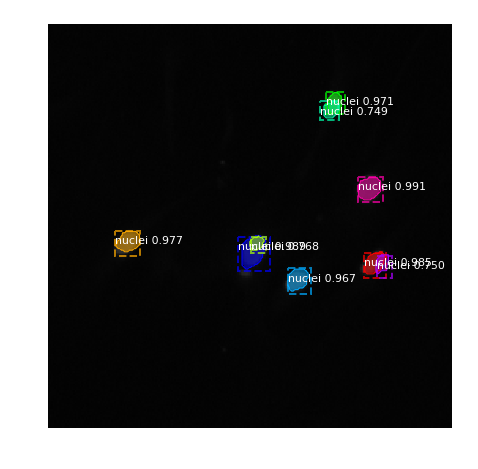

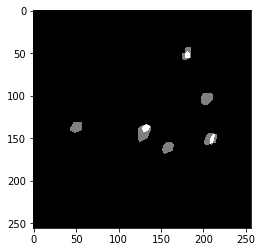

In [8]:
image_id = random.choice(dataset_tes.image_ids)
image_path = test_ids[image_id]
image_path = "0114f484a16c152baa2d82fdd43740880a762c93f436c8988ac461c5c9dbe7d5"
im_path = TEST_PATH + '/{}/images/{}.png'.format(image_path, image_path)
original_image = cv2.imread(str(im_path))[:,:,:3]

results = model.detect([original_image], verbose=1)
r = results[0]
idx = utils.non_max_suppression(r['rois'], r['scores'], 0.4)
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_tes.class_names, r['scores'], ax=get_ax())

k = np.zeros((r['masks'].shape[0], r['masks'].shape[1]))
for i in range(len(idx)):
    k += r['masks'][:,:,idx[i]]
plt.imshow(k,cmap='gray')
plt.show()


In [13]:
def numpy2encoding_no_overlap2(predicts, img_name, scores):
    """predicts: [H, W, N] instance binary masks
    注意： 中间可能有洞
    overlapping parts are given to the instance of highest score (i.e. DETECTION CONFIDENCE)
    """
    # refine your masks here !
#    predicts = np.apply_along_axis(refineMasks, 2, predicts)
#    for i in range(predicts.shape[2]-1):
#        predicts[:,:,i] = refineMasks(predicts[:,:,i])
#    
    sum_predicts = np.sum(predicts, axis=2)
    rows, cols = np.where(sum_predicts>=2)
    
    for i in zip(rows, cols):
        instance_indicies = np.where(np.any(predicts[i[0],i[1],:]))[0]
        highest = instance_indicies[0]
        predicts[i[0],i[1],:] = predicts[i[0],i[1],:]*0
        predicts[i[0],i[1],highest] = 1
    
    ImageId = []
    EncodedPixels = []
    for i in range(predicts.shape[2]): 
        rle = run_length_encoding(predicts[:,:,i])
        if len(rle)>0:
            ImageId.append(img_name)
            EncodedPixels.append(rle)    
    return ImageId, EncodedPixels

def run_length_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    run_lengths = ' '.join([str(r) for r in run_lengths])
    return run_lengths

In [20]:
final_masks = []
ImageId = []
EncodedPixels = []
for i in range(len(train_ids)):
    image_path = train_ids[i]

    im_path = train_dir + '/{}/images/{}.png'.format(image_path, image_path)
    original_image = cv2.imread(str(im_path))
    results = model.detect([original_image], verbose=1)
    r = results[0]
    idx = utils.non_max_suppression(r['rois'], r['scores'], 0.2)
    ImageId_batch, EncodedPixels_batch = numpy2encoding_no_overlap2(r['masks'], image_path, r['scores'])
    ImageId += ImageId_batch
    EncodedPixels += EncodedPixels_batch

    

Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  108.00000
molded_images            shape: (1, 128, 128, 3)      min: -121.70000  max:   -0.90000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000
Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  255.00000
molded_images            shape: (1, 128, 128, 3)      min: -121.70000  max:  110.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000
Processing 1 images
image                    shape: (256, 320, 3)         min:   15.00000  max:  235.00000
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:  122.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  320.00000
Processing 1 images
image                    shape: (256, 320, 3)         min:   23.00000  max:  241.00000
molded_images            shape: (1, 128, 128, 3)  

image                    shape: (520, 696, 3)         min:    8.00000  max:   79.00000
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:  -41.90000
image_metas              shape: (1, 10)               min:    0.00000  max:  696.00000
Processing 1 images
image                    shape: (256, 256, 3)         min:   10.00000  max:  164.00000
molded_images            shape: (1, 128, 128, 3)      min: -111.70000  max:   37.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000
Processing 1 images
image                    shape: (256, 256, 3)         min:    9.00000  max:  255.00000
molded_images            shape: (1, 128, 128, 3)      min: -112.70000  max:  146.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000
Processing 1 images
image                    shape: (256, 320, 3)         min:   14.00000  max:  218.00000
molded_images            shape: (1, 128, 128, 3)      min: -123.70000 

image                    shape: (256, 320, 3)         min:   21.00000  max:  242.00000
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:  121.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  320.00000
Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  115.00000
molded_images            shape: (1, 128, 128, 3)      min: -122.70000  max:    6.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000
Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  102.00000
molded_images            shape: (1, 128, 128, 3)      min: -121.70000  max:   -9.90000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000
Processing 1 images
image                    shape: (520, 696, 3)         min:    0.00000  max:  186.00000
molded_images            shape: (1, 128, 128, 3)      min: -123.70000 

image                    shape: (256, 256, 3)         min:    9.00000  max:  255.00000
molded_images            shape: (1, 128, 128, 3)      min: -112.70000  max:  126.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000
Processing 1 images
image                    shape: (256, 256, 3)         min:    9.00000  max:  255.00000
molded_images            shape: (1, 128, 128, 3)      min: -112.70000  max:  143.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000
Processing 1 images
image                    shape: (603, 1272, 3)        min:    0.00000  max:  128.00000
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:  -53.90000
image_metas              shape: (1, 10)               min:    0.00000  max: 1272.00000
Processing 1 images
image                    shape: (512, 640, 3)         min:    0.00000  max:  105.00000
molded_images            shape: (1, 128, 128, 3)      min: -123.70000 

image                    shape: (256, 256, 3)         min:    1.00000  max:  137.00000
molded_images            shape: (1, 128, 128, 3)      min: -121.70000  max:   29.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000
Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  100.00000
molded_images            shape: (1, 128, 128, 3)      min: -119.70000  max:  -11.90000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000
Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  210.00000
molded_images            shape: (1, 128, 128, 3)      min: -121.70000  max:   91.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000
Processing 1 images
image                    shape: (256, 320, 3)         min:   19.00000  max:  230.00000
molded_images            shape: (1, 128, 128, 3)      min: -123.70000 

image                    shape: (520, 696, 3)         min:   10.00000  max:  215.00000
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:   93.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  696.00000
Processing 1 images
image                    shape: (256, 320, 3)         min:   16.00000  max:  249.00000
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:  120.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  320.00000
Processing 1 images
image                    shape: (256, 256, 3)         min:   10.00000  max:  255.00000
molded_images            shape: (1, 128, 128, 3)      min: -112.70000  max:  122.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000
Processing 1 images
image                    shape: (256, 256, 3)         min:   11.00000  max:  255.00000
molded_images            shape: (1, 128, 128, 3)      min: -110.70000 

image                    shape: (256, 256, 3)         min:    0.00000  max:   84.00000
molded_images            shape: (1, 128, 128, 3)      min: -122.70000  max:  -21.90000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000
Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  183.00000
molded_images            shape: (1, 128, 128, 3)      min: -120.70000  max:   50.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000
Processing 1 images
image                    shape: (256, 320, 3)         min:    0.00000  max:  231.00000
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:  119.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  320.00000
Processing 1 images
image                    shape: (256, 320, 3)         min:   23.00000  max:  254.00000
molded_images            shape: (1, 128, 128, 3)      min: -123.70000 

image                    shape: (256, 320, 3)         min:    4.00000  max:  216.00000
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:   90.30000
image_metas              shape: (1, 10)               min:    0.00000  max:  320.00000
Processing 1 images
image                    shape: (520, 696, 3)         min:   13.00000  max:  226.00000
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:  119.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  696.00000
Processing 1 images
image                    shape: (256, 320, 3)         min:    0.00000  max:  221.00000
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:   90.30000
image_metas              shape: (1, 10)               min:    0.00000  max:  320.00000
Processing 1 images
image                    shape: (520, 696, 3)         min:    0.00000  max:  106.00000
molded_images            shape: (1, 128, 128, 3)      min: -123.70000 

image                    shape: (256, 256, 3)         min:   10.00000  max:  255.00000
molded_images            shape: (1, 128, 128, 3)      min: -111.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000
Processing 1 images
image                    shape: (360, 360, 3)         min:    4.00000  max:   53.00000
molded_images            shape: (1, 128, 128, 3)      min: -118.70000  max:  -53.90000
image_metas              shape: (1, 10)               min:    0.00000  max:  360.00000
Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  128.00000
molded_images            shape: (1, 128, 128, 3)      min: -121.70000  max:   13.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000
Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:   87.00000
molded_images            shape: (1, 128, 128, 3)      min: -121.70000 

image                    shape: (1024, 1024, 3)       min:   47.00000  max:  246.00000
molded_images            shape: (1, 128, 128, 3)      min:  -63.70000  max:  132.10000
image_metas              shape: (1, 10)               min:    0.00000  max: 1024.00000
Processing 1 images
image                    shape: (256, 320, 3)         min:    3.00000  max:  217.00000
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:   88.30000
image_metas              shape: (1, 10)               min:    0.00000  max:  320.00000
Processing 1 images
image                    shape: (520, 696, 3)         min:    0.00000  max:  174.00000
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:   32.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  696.00000
Processing 1 images
image                    shape: (520, 696, 3)         min:    8.00000  max:   80.00000
molded_images            shape: (1, 128, 128, 3)      min: -123.70000 

image                    shape: (520, 696, 3)         min:   14.00000  max:  217.00000
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:  102.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  696.00000
Processing 1 images
image                    shape: (520, 696, 3)         min:    0.00000  max:   95.00000
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:  -29.90000
image_metas              shape: (1, 10)               min:    0.00000  max:  696.00000
Processing 1 images
image                    shape: (520, 696, 3)         min:    0.00000  max:  155.00000
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:    1.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  696.00000
Processing 1 images
image                    shape: (360, 360, 3)         min:    2.00000  max:   83.00000
molded_images            shape: (1, 128, 128, 3)      min: -121.70000 

image                    shape: (256, 320, 3)         min:   20.00000  max:  240.00000
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:  117.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  320.00000
Processing 1 images
image                    shape: (360, 360, 3)         min:    5.00000  max:   61.00000
molded_images            shape: (1, 128, 128, 3)      min: -117.70000  max:  -46.90000
image_metas              shape: (1, 10)               min:    0.00000  max:  360.00000
Processing 1 images
image                    shape: (256, 320, 3)         min:    0.00000  max:  216.00000
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:   87.30000
image_metas              shape: (1, 10)               min:    0.00000  max:  320.00000
Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  109.00000
molded_images            shape: (1, 128, 128, 3)      min: -121.70000 

image                    shape: (256, 256, 3)         min:    1.00000  max:   90.00000
molded_images            shape: (1, 128, 128, 3)      min: -121.70000  max:  -15.90000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000
Processing 1 images
image                    shape: (360, 360, 3)         min:    1.00000  max:   41.00000
molded_images            shape: (1, 128, 128, 3)      min: -121.70000  max:  -65.90000
image_metas              shape: (1, 10)               min:    0.00000  max:  360.00000
Processing 1 images
image                    shape: (256, 256, 3)         min:    9.00000  max:  203.00000
molded_images            shape: (1, 128, 128, 3)      min: -112.70000  max:   75.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000
Processing 1 images
image                    shape: (256, 256, 3)         min:    9.00000  max:  108.00000
molded_images            shape: (1, 128, 128, 3)      min: -112.70000 

image                    shape: (256, 256, 3)         min:   10.00000  max:  255.00000
molded_images            shape: (1, 128, 128, 3)      min: -112.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000
Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  138.00000
molded_images            shape: (1, 128, 128, 3)      min: -120.70000  max:   30.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000
Processing 1 images
image                    shape: (1024, 1024, 3)       min:   45.00000  max:  244.00000
molded_images            shape: (1, 128, 128, 3)      min:  -63.70000  max:  129.10000
image_metas              shape: (1, 10)               min:    0.00000  max: 1024.00000
Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  131.00000
molded_images            shape: (1, 128, 128, 3)      min: -121.70000 

image                    shape: (256, 256, 3)         min:    9.00000  max:  248.00000
molded_images            shape: (1, 128, 128, 3)      min: -112.70000  max:  116.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000
Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  141.00000
molded_images            shape: (1, 128, 128, 3)      min: -121.70000  max:   27.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000
Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  113.00000
molded_images            shape: (1, 128, 128, 3)      min: -121.70000  max:    4.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000
Processing 1 images
image                    shape: (256, 256, 3)         min:   10.00000  max:  252.00000
molded_images            shape: (1, 128, 128, 3)      min: -111.70000 

image                    shape: (256, 320, 3)         min:    2.00000  max:  255.00000
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  320.00000
Processing 1 images
image                    shape: (256, 256, 3)         min:    9.00000  max:  180.00000
molded_images            shape: (1, 128, 128, 3)      min: -112.70000  max:   61.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000
Processing 1 images
image                    shape: (520, 696, 3)         min:    1.00000  max:  255.00000
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:   92.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  696.00000
Processing 1 images
image                    shape: (360, 360, 3)         min:    2.00000  max:   59.00000
molded_images            shape: (1, 128, 128, 3)      min: -121.70000 

image                    shape: (256, 256, 3)         min:    9.00000  max:  255.00000
molded_images            shape: (1, 128, 128, 3)      min: -113.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000
Processing 1 images
image                    shape: (520, 696, 3)         min:    9.00000  max:  205.00000
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:   96.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  696.00000
Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  155.00000
molded_images            shape: (1, 128, 128, 3)      min: -120.70000  max:   44.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000
Processing 1 images
image                    shape: (360, 360, 3)         min:    3.00000  max:   80.00000
molded_images            shape: (1, 128, 128, 3)      min: -119.70000 

image                    shape: (256, 256, 3)         min:    0.00000  max:   79.00000
molded_images            shape: (1, 128, 128, 3)      min: -121.70000  max:  -28.90000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000
Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  147.00000
molded_images            shape: (1, 128, 128, 3)      min: -120.70000  max:   32.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000
Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  114.00000
molded_images            shape: (1, 128, 128, 3)      min: -120.70000  max:    4.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000
Processing 1 images
image                    shape: (256, 320, 3)         min:   24.00000  max:  240.00000
molded_images            shape: (1, 128, 128, 3)      min: -123.70000 

image                    shape: (256, 256, 3)         min:    9.00000  max:  255.00000
molded_images            shape: (1, 128, 128, 3)      min: -112.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000
Processing 1 images
image                    shape: (1024, 1024, 3)       min:   28.00000  max:  245.00000
molded_images            shape: (1, 128, 128, 3)      min:  -69.70000  max:  131.10000
image_metas              shape: (1, 10)               min:    0.00000  max: 1024.00000
Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  132.00000
molded_images            shape: (1, 128, 128, 3)      min: -120.70000  max:   19.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000
Processing 1 images
image                    shape: (520, 696, 3)         min:    0.00000  max:  231.00000
molded_images            shape: (1, 128, 128, 3)      min: -123.70000 

image                    shape: (256, 256, 3)         min:    8.00000  max:  255.00000
molded_images            shape: (1, 128, 128, 3)      min: -113.70000  max:  142.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000
Processing 1 images
image                    shape: (256, 320, 3)         min:    3.00000  max:  255.00000
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:  133.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  320.00000
Processing 1 images
image                    shape: (256, 256, 3)         min:   10.00000  max:  240.00000
molded_images            shape: (1, 128, 128, 3)      min: -111.70000  max:  117.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000
Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  174.00000
molded_images            shape: (1, 128, 128, 3)      min: -121.70000 

image                    shape: (520, 696, 3)         min:    0.00000  max:  127.00000
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:  -11.90000
image_metas              shape: (1, 10)               min:    0.00000  max:  696.00000
Processing 1 images
image                    shape: (256, 256, 3)         min:    9.00000  max:  255.00000
molded_images            shape: (1, 128, 128, 3)      min: -112.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000
Processing 1 images
image                    shape: (360, 360, 3)         min:    4.00000  max:   45.00000
molded_images            shape: (1, 128, 128, 3)      min: -118.70000  max:  -62.90000
image_metas              shape: (1, 10)               min:    0.00000  max:  360.00000
Processing 1 images
image                    shape: (256, 256, 3)         min:   10.00000  max:  255.00000
molded_images            shape: (1, 128, 128, 3)      min: -112.70000 

image                    shape: (256, 256, 3)         min:    9.00000  max:  255.00000
molded_images            shape: (1, 128, 128, 3)      min: -112.70000  max:  133.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000
Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  164.00000
molded_images            shape: (1, 128, 128, 3)      min: -120.70000  max:   50.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000
Processing 1 images
image                    shape: (256, 320, 3)         min:   18.00000  max:  246.00000
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:  113.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  320.00000
Processing 1 images
image                    shape: (256, 256, 3)         min:    2.00000  max:  109.00000
molded_images            shape: (1, 128, 128, 3)      min: -120.70000 

image                    shape: (603, 1272, 3)        min:    0.00000  max:  117.00000
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:  -56.90000
image_metas              shape: (1, 10)               min:    0.00000  max: 1272.00000
Processing 1 images
image                    shape: (520, 696, 3)         min:    9.00000  max:  158.00000
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:   34.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  696.00000
Processing 1 images
image                    shape: (256, 256, 3)         min:    8.00000  max:   78.00000
molded_images            shape: (1, 128, 128, 3)      min: -113.70000  max:  -35.90000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000
Processing 1 images
image                    shape: (256, 256, 3)         min:    9.00000  max:  168.00000
molded_images            shape: (1, 128, 128, 3)      min: -111.70000 

image                    shape: (520, 696, 3)         min:    9.00000  max:  156.00000
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:   31.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  696.00000
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:   77.00000
molded_images            shape: (1, 128, 128, 3)      min: -122.70000  max:  -30.90000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000
Processing 1 images
image                    shape: (360, 360, 3)         min:    3.00000  max:   47.00000
molded_images            shape: (1, 128, 128, 3)      min: -119.70000  max:  -58.90000
image_metas              shape: (1, 10)               min:    0.00000  max:  360.00000


In [46]:
for i in range(len(test_ids)):
    image_path = test_ids[image_id]
print(np.max(final_masks))

ValueError: operands could not be broadcast together with shapes (256,256) (519,253) 

In [21]:
def write2csv(file, ImageId, EncodedPixels):
    df = pd.DataFrame({ 'ImageId' : ImageId , 'EncodedPixels' : EncodedPixels})
    df.to_csv(file, index=False, columns=['ImageId', 'EncodedPixels'])

write2csv('submission_v2_train.csv', ImageId, EncodedPixels)

In [57]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(final_masks[n]))
    
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))
    


In [58]:
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-dsbowl2018-3.csv', index=False)